In [1]:
%pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 11.2 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset("martingrzzler/kanjis2radicals")

Generating train split: 0 examples [00:00, ? examples/s]

Dataset kanjis2radicals downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___kanjis2radicals/default/0.0.0/275e8ee81763b2d0e8161bc5b3b4cc22fbb2cf69c7a4e80e08a840a278b81552. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
ds['train'].features

{'kanji_image': Image(decode=True, id=None),
 'meta': {'id': Value(dtype='int32', id=None),
  'characters': Value(dtype='string', id=None),
  'meanings': Value(dtype='string', id=None),
  'radicals': Sequence(feature={'characters': Value(dtype='string', id=None), 'id': Value(dtype='int32', id=None), 'slug': Value(dtype='string', id=None)}, length=-1, id=None)}}

{'kanji_image': <PIL.PngImagePlugin.PngImageFile image mode=L size=64x64 at 0x7F23ECA6FEB0>, 'meta': {'id': 2083, 'characters': '丈', 'meanings': 'Height,Ten Feet', 'radicals': {'characters': ['丈'], 'id': [408], 'slug': ['height']}}}


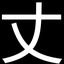

In [4]:
idx = 5
print(ds['train'][idx])
ds['train'][idx]['kanji_image']

In [5]:
import numpy as np
radical_range = set(range(1,440))
radical_ids = set()

for meta in ds['train']['meta']:
    for id in meta['radicals']['id']:
        if id <= 439:
            radical_ids.add(id)

unique_radical_ids = sorted(list(radical_ids))
num_classes = len(unique_radical_ids)
radical_id_to_index = {radical_id: idx for idx, radical_id in enumerate(unique_radical_ids)}

In [6]:
missing_radical_ids = radical_range - radical_ids

In [7]:
missing_radical_ids

{58, 59, 70, 133, 225, 316, 335, 375, 386, 401}

In [8]:
radical_ds = load_dataset("martingrzzler/radicals")

Generating train split: 0 examples [00:00, ? examples/s]

Dataset radicals downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___radicals/default/0.0.0/d06fa45bbf364a018a5727e22360769bec2306739b86877c63d2734b6fad32e7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
radical_ids = set()
for meta in radical_ds['train']['meta']:
    radical_ids.add(meta['id'])

unique_radical_ids = sorted(list(radical_ids))
num_classes = len(unique_radical_ids)
radical_id_to_index = {radical_id: idx for idx, radical_id in enumerate(unique_radical_ids)}

In [10]:
num_classes

439

In [11]:
def filter_unsupported_radicals(example):
    for id in example['meta']['radicals']['id']:
        if id > 439:
            return False
    return True

In [18]:
filtered_ds = ds['train'].filter(filter_unsupported_radicals)
filtered_ds = filtered_ds.map(lambda example: {'kanji_id': example['meta']['id']})

Map:   0%|          | 0/1750 [00:00<?, ? examples/s]

In [32]:
filtered_ds = filtered_ds.sort(['kanji_id'])

curriculums = []
curriculums_len = len(filtered_ds) // 5
for i in range(0, len(filtered_ds), curriculums_len):
    curriculums.append(filtered_ds.select(range(i, i + curriculums_len)))



In [23]:
import numpy as np

def one_hot_encode(example):
    radical_indices = [radical_id_to_index[id] for id in example["meta"]["radicals"]["id"]]
    one_hot = np.zeros(len(unique_radical_ids))
    one_hot[radical_indices] = 1
    return {"labels": one_hot}

In [74]:
ds_one_hot = curriculums[0].map(one_hot_encode)

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

In [75]:
ds_train = ds_one_hot.remove_columns(["meta"])

In [139]:
import random

def random_rotate_image(image):
    angle = random.choice([0, 90, 180, 270])
    return image.rotate(angle)

In [140]:
from datasets import Dataset
rotated_samples = []

angles = [0, 90, 180, 270]

for i in range(len(ds_train)):
    example = ds_train[i].copy()
    rotated_samples.append(example)
    for i in range(len(angles)):
        rotated_example = example.copy()
        rotated_example['kanji_image'] = example['kanji_image'].rotate(angles[i])
        rotated_samples.append(rotated_example)


In [76]:
import pandas as pd
rotated_ds = Dataset.from_dict(pd.DataFrame(rotated_samples))

NameError: name 'Dataset' is not defined

In [77]:
# rotated_ds.set_format(type='torch', columns=['kanji_image', 'labels'])
ds_train.set_format(type='torch', columns=['kanji_image', 'labels'])

In [78]:
normalized_ds = ds_train.map(lambda example: {'kanji_image': example['kanji_image'].unsqueeze(0) / 255.0})

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

In [79]:
splits = normalized_ds.train_test_split(test_size=0.1, shuffle=True)

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(107648, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.fc3 = nn.Linear(num_classes, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.sigmoid(x)
        return output

model = Net(num_classes)

In [81]:
import torch

best_radical_state_dict = torch.load('v1_best.pt')
new_state_dict = model.state_dict()

for key in best_radical_state_dict:
    if key.startswith('fc3'):
        continue
    new_state_dict[key] = best_radical_state_dict[key]


In [82]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [98]:
# # freeze pretrained layers
# for param in model.parameters():
#     param.requires_grad = False

# # unfreeze last layer
# for param in model.fc3.parameters():
#     param.requires_grad = True

In [83]:
from torch.utils.data import DataLoader

batch_size = 8

splits.set_format(type='torch', columns=['kanji_image', 'labels'])
train_loader = DataLoader(splits['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(splits['test'], batch_size=batch_size, shuffle=False)

In [84]:
import torch
import torch.nn as nn

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [85]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=107648, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=439, bias=True)
  (fc3): Linear(in_features=439, out_features=439, bias=True)
)

In [86]:
train_loader.dataset[0]['kanji_image'].shape

torch.Size([1, 64, 64])

In [90]:
losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for idx, batch in enumerate(train_loader):
        images, labels = batch['kanji_image'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step {idx+1}/{len(train_loader)}, Loss: {loss.item()}")

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch['kanji_image'].to(device), batch['labels'].to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {test_loss/len(test_loader)}")

Epoch 1/10, Step 1/40, Loss: 0.02950112707912922
Epoch 1/10, Step 11/40, Loss: 0.02970702387392521
Epoch 1/10, Step 21/40, Loss: 0.029963556677103043
Epoch 1/10, Step 31/40, Loss: 0.026512883603572845
Epoch 1/10, Train Loss: 0.028970342129468918, Val Loss: 0.028078201040625573
Epoch 2/10, Step 1/40, Loss: 0.029802067205309868
Epoch 2/10, Step 11/40, Loss: 0.03246661648154259
Epoch 2/10, Step 21/40, Loss: 0.022536708042025566
Epoch 2/10, Step 31/40, Loss: 0.02556964010000229
Epoch 2/10, Train Loss: 0.030800024420022963, Val Loss: 0.027711467817425728
Epoch 3/10, Step 1/40, Loss: 0.029124433174729347
Epoch 3/10, Step 11/40, Loss: 0.024336811155080795
Epoch 3/10, Step 21/40, Loss: 0.031075969338417053
Epoch 3/10, Step 31/40, Loss: 0.026449205353856087
Epoch 3/10, Train Loss: 0.02746882466599345, Val Loss: 0.028096194192767144
Epoch 4/10, Step 1/40, Loss: 0.03066120482981205
Epoch 4/10, Step 11/40, Loss: 0.03229754418134689
Epoch 4/10, Step 21/40, Loss: 0.02736651338636875
Epoch 4/10, Step

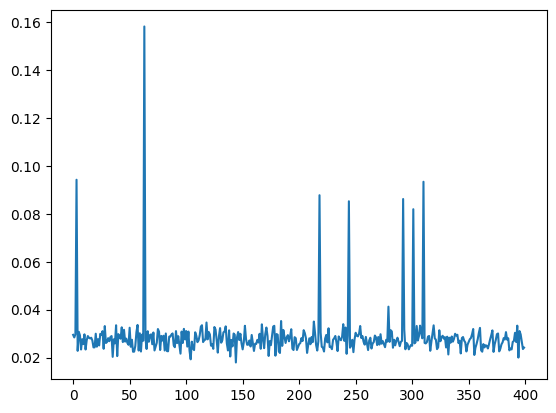

In [91]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [65]:
def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).unsqueeze(0).to(device) / 255.0
        print(image.shape)
        output = model(image)
        return output

In [72]:
predict(model, ds_train[5]['kanji_image']).argmax()

torch.Size([1, 1, 64, 64])


tensor(22, device='cuda:0')

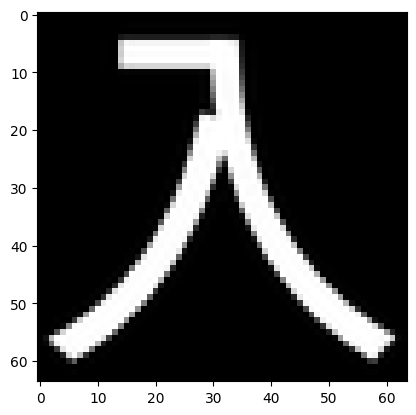

In [73]:
import matplotlib.pyplot as plt

plt.imshow(ds_train[5]['kanji_image'], cmap='gray')

In [60]:
import numpy as np
from sklearn.metrics import f1_score

threshold = 0.1

model.eval()
all_ground_truth = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        image, labels = batch['kanji_image'].to(device), batch['labels'].to(device)
        outputs = model(image)
        bool_outputs = (outputs > threshold).cpu().numpy()
        all_predictions.extend(bool_outputs)
        
        all_ground_truth.extend(labels.cpu().numpy())

y_true = np.array(all_ground_truth)
y_pred = np.array(all_predictions)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

for i in range(10):
    print("Ground Truth:", np.where(y_true[i] == 1)[0])
    print("Predictions:", np.where(y_pred[i] == 1)[0])
    print()

F1 Score: 0.008738972825865717
Ground Truth: [ 61 160 423]
Predictions: []

Ground Truth: [218 419]
Predictions: []

Ground Truth: [175 332]
Predictions: []

Ground Truth: [ 59 273]
Predictions: []

Ground Truth: [102 341]
Predictions: []

Ground Truth: [ 89 216 361]
Predictions: []

Ground Truth: [ 84 215]
Predictions: []

Ground Truth: [ 42 326]
Predictions: [15 22]

Ground Truth: [ 74 320]
Predictions: [15 22 62]

Ground Truth: [ 10 169]
Predictions: [15]



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
